Timelabels: https://cloud.google.com/speech-to-text/docs/async-time-offsets#speech-async-recognize-gcs-python

In [1]:
from __future__ import print_function

import vidtimit_module
from pprint import pprint
from tabulate import tabulate
import string
import json
import wave
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os.path
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import io
import os
import hashlib
from datetime import datetime

%matplotlib inline
from pylab import rcParams

# Imports the Google Cloud client library
from google.cloud import speech
from google.cloud import speech_v1
from google.cloud.speech import enums
from google.cloud.speech import types
from google.cloud import storage
from google.cloud.speech_v1 import enums


In [2]:
# If modifying these scopes, delete the file token.pickle.
SCOPES = ['https://www.googleapis.com/auth/drive.metadata.readonly']

def main():
    """Shows basic usage of the Drive v3 API.
    Prints the names and ids of the first 10 files the user has access to.
    """
    creds = None
    # The file token.pickle stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('drive', 'v3', credentials=creds)

    # Call the Drive v3 API
    results = service.files().list(
        pageSize=10, fields="nextPageToken, files(id, name)").execute()
    items = results.get('files', [])
    
    print("Connection successful")

if __name__ == '__main__':
    # main()
    pass

#### Various useful functions

In [3]:
# Various useful functions.

# Returns the number of channels in a audio file
def get_number_of_channels(filename):
    rate, audio = wavfile.read(file_name)
    
    try:
        return audio.shape[1]
    except:
        return 1

# Returns True if the number of channels in the audiofile is 2, False if anything else
def is_stereo(filename):
    return get_number_of_channels(filename) == 2

# Returns the rate of the audio file
def get_rate(filename):
    return wavfile.read(filename)[0]
 
# Returns the data of the audio file
def get_data(filename):
    return wavfile.read(filename)[1]

# Returns the duration of the audiofile in seconds can be rounded
def get_duration(filename, rounding=None):
    rate, data = wavfile.read(filename)
    duration = data.shape[0] / rate
    
    if rounding:
        return round(duration, rounding)
    return duration

# Writes the a new audio file that is a slowed down version of the audio passed to it
def slow_down_audio(filename, slow_percent):
    rate, data = wavfile.read(filename)
    
    slow_rate = rate/100
    slow_rate *= 100-slow_percent
    slow_rate = int(slow_rate)
    
    slow_filename = filename.replace(".wav", "_SLOWED{}p.wav".format(slow_percent))
    
    wavfile.write(slow_filename, slow_rate, data)
    
    return slow_rate, slow_filename

# Removes one of the audio channels, there is not normalising, just removal
def convert_stereo_to_mono(filename):
    rate, audio = wavfile.read(filename)
    
    # Create a backup of the stereo
    wavfile.write(filename.replace(".wav", "STEREO.wav"), rate, audio)
    
    # Write over the existing as mono
    wavfile.write(filename, rate, audio[:, :1])

# Returns all the words in a tabulated structure, including the timestamps and duration
def get_tabulated_words(words):
    the_words = list()
    start_times = list()
    end_times = list()
    durations = list()
    duration_zero = list()
    
    for word in words:
        the_words.append(word["word"])
        start_times.append(word["start"])
        end_times.append(word["end"])
        durations.append(word["duration"])
        if word["duration"]:
            duration_zero.append(None)
        else:
            duration_zero.append("EMPTY")

    return tabulate({
        "Word": the_words,
        "Start (s)": start_times,
        "End (s)": end_times,
        "Duration (s)": durations,
        "Duration Zero": duration_zero
    }, headers="keys")

# Determines the hash of a audio file
def get_hash(filename):
    rate, data = wavfile.read(filename)
    
    data = tuple(data)
    
    return hash(hash(data)*hash(rate))

# Checks if the hash exists
def hash_exists(audio_hash):
    return audio_hash in [int(file.replace(".json", "")) for file in os.listdir("timestamps database")]

# The date format used in this program
def date_format():
    return "%d-%m-%Y %H:%M:%S"

def frame(text):
    print("+-"+"-"*len(text)+"-+")
    print("| {} |".format(text))
    print("+-"+"-"*len(text)+"-+")


#### Log in to google transcription explicitly
Usually it is possible to log in implicitly by letting Python know where to find the login details. However, this is problematic when using Jypyter, so it is easier to just do it explicitly.

In [4]:
def explicit():
    from google.cloud import storage

    # Explicitly use service account credentials by specifying the private key file.
    storage_client = storage.Client.from_service_account_json('Vidtimit Transcription-6b9ad6f8da98.json')

    # Make an authenticated API request
    buckets = list(storage_client.list_buckets())
    if buckets:
        print(buckets)

explicit()

[<Bucket: transcriber_for_thesis>]


#### Send the audio file to google for transcription

In [5]:
def transcribe(file_name):
    """
    Transcribe long audio file from Cloud Storage using asynchronous speech
    recognition

    Args:
      storage_uri URI for audio file in Cloud Storage, e.g. gs://[BUCKET]/[FILE]
    """

    client = speech_v1.SpeechClient.from_service_account_json('Vidtimit Transcription-6b9ad6f8da98.json')

    config = {
        "encoding": enums.RecognitionConfig.AudioEncoding.LINEAR16,
        "language_code": "en-US",
        "sample_rate_hertz": rate,
        "enable_word_time_offsets": True
    }
    storage_uri = "gs://transcriber_for_thesis/{}".format(file_name)
    audio = {"uri": storage_uri}

    operation = client.long_running_recognize(config, audio)

    print(u"Waiting for operation to complete...")
    response = operation.result()
    
    return response.results

In [6]:
"""
print(transcribe_results.results)
write_to_file(transcribe_results.results)
"""


'\nprint(transcribe_results.results)\nwrite_to_file(transcribe_results.results)\n'

#### Write to file
Collect everything and write it to a JSON file. The name of this file will be the hash of the audio file "{hash}.json", determined by the function 'get_hash' above.

In [7]:
def write_to_file(transcription):
    complete_results = dict()
    complete_results["rate"] = rate
    complete_results["audio signals"] = len(get_data(file_name))
    complete_results["created"] = datetime.utcnow().strftime(date_format())
    complete_results["volume"] = len(transcription)
    complete_results["audio_file"] = file_name_short
    complete_results["slowed"] = "SLOWED" in file_name
    if complete_results["slowed"]:
        complete_results["slow percent"] = slow_percent

    complete_results["results"] = list()

    for transcribe_result in transcription:
        sentence = transcribe_result.alternatives[0]

        result = dict()
        result["confidence"] = sentence.confidence
        result["transcript"] = sentence.transcript

        result["words"] = list()
        for word in sentence.words:
            word_dict = dict()

            word_dict["word"] = word.word
            word_dict["start"] = float("{}.{}".format(word.start_time.seconds, str(word.start_time.nanos)[0]))
            word_dict["end"] = float("{}.{}".format(word.end_time.seconds, str(word.end_time.nanos)[0]))
            word_dict["duration"] = round(float(word_dict["end"])-float(word_dict["start"]), 1)

            result["words"].append(word_dict)

        complete_results["results"].append(result)

        output_filename = os.path.join("timestamps database", "{}.json".format(get_hash(file_name)))

        # Dump the dictionary to a json file
        with open(output_filename, "w") as json_file:
            json.dump(complete_results, json_file, indent=2)

#### Load from file

In [8]:
def load_from_file(audio_hash):
    
    with open(os.path.join("timestamps database", "{}.json".format(audio_hash)), 'r') as file:
        json_data = json.load(file)
    
    print("Hash {} was created at {}".format(audio_hash, json_data["created"]))
    
    created = datetime.strptime(json_data["created"], date_format())
    now = datetime.utcnow().strftime(date_format())
    now = datetime.strptime(now, date_format())
    
    age = abs(now - created)

    print("Age: {}".format(age))
    
    return json_data

#### Determine the file name and path

In [9]:
# The name of the actual .wav file to transcribe
file_name_short = "Can-You-Bake-Cookies-On-A-Comput.wav"

# Determine the file path
file_path = os.path.join("youtube material")

# Combine the path and the file name and use this from now on
file_name = os.path.join(file_path, file_name_short)

# Print the duration of the file
print("Duration: {}s".format(round(get_duration(file_name), 2)))

Duration: 672.26s


#### Collect some data from the file and convert to mono if neccesary

In [10]:
# Check if the file is stereo, if it is convert to mono and write over the existing file
if is_stereo(file_name):
    print("Had to convert to mono. File permanently overwritten as mono.")
    convert_stereo_to_mono(file_name)
else:
    print("Audio is mono")

# Collect some information about the file
rate = get_rate(file_name)
data = get_data(file_name)

print("Rate: {}Hz".format(rate))

# How much to slow the audio with. A value of 20 would make the audio file run at 80% speed
slow_percent = 20

# If this is a slowed down file already, do not slow it further
if "SLOWED" not in file_name_short and slow_percent:
    slow_rate, slow_filename = slow_down_audio(file_name, slow_percent)
    
    print("Wrote slowed file. Slowed by {}%".format(slow_percent))
    print("Slow filename: {}".format(slow_filename.split("\\")[-1]))
    print()
    print("    Rate: {}Hz->{}Hz".format(rate, slow_rate)) 
    print("Duration: {}s->{}s".format(get_duration(file_name, 2), get_duration(slow_filename, 2)))

audio_hash = get_hash(file_name)
print("Hash exists: {}".format(hash_exists(audio_hash)))

# If this hash is found in the folder, then that file will be loaded, and nothing will be sent to Google transcribe.
# If it is desired to retrieve fresh transcript, set this to True
ignore_file = False

Audio is mono
Rate: 44100Hz
Wrote slowed file. Slowed by 20%
Slow filename: Can-You-Bake-Cookies-On-A-Comput_SLOWED20p.wav

    Rate: 44100Hz->35280Hz
Duration: 672.26s->840.33s
Hash exists: True


#### Check content of bucket

In [11]:
def list_blobs(bucket_name):
    """Lists all the blobs in the bucket."""
    # bucket_name = "your-bucket-name"

    storage_client = storage.Client.from_service_account_json('Vidtimit Transcription-6b9ad6f8da98.json')

    # Note: Client.list_blobs requires at least package version 1.17.0.
    blobs = storage_client.list_blobs(bucket_name)

    for blob in blobs:
        print(blob.name)

list_blobs("transcriber_for_thesis")

can you bake cookies on a computer processor 100p
can you bake cookies on a computer processor 10p
can you bake cookies on a computer processor 1p
can you bake cookies on a computer processor 50p
can you bake cookies on a computer processor 80p


#### Write to file if neccessary
If the audio has not been transcribed yet, transcribe it and write to file immediately.

In [12]:
"""
if ignore_file or not hash_exists(audio_hash):
    print("Hash does not exist, transcribing and writing to file.")
    transcribe_results = sample_long_running_recognize("gs://transcriber_for_thesis/I-Bought-a-9-1TB-SD-Card-and-Got.wav")
    
    write_to_file(transcribe_results)
    print("Wrote {}.json.".format(audio_hash))
else:
    print("Hash {} already exists.".format(audio_hash))
    
print(transcribe_results)
"""


'\nif ignore_file or not hash_exists(audio_hash):\n    print("Hash does not exist, transcribing and writing to file.")\n    transcribe_results = sample_long_running_recognize("gs://transcriber_for_thesis/I-Bought-a-9-1TB-SD-Card-and-Got.wav")\n    \n    write_to_file(transcribe_results)\n    print("Wrote {}.json.".format(audio_hash))\nelse:\n    print("Hash {} already exists.".format(audio_hash))\n    \nprint(transcribe_results)\n'

In [13]:
if ignore_file or not hash_exists(audio_hash):
    print("Hash does not exist, transcribing and writing to file.")
    transcribe_results = transcribe(file_name_short)
    write_to_file(transcribe_results)
    print("Wrote {}.json.".format(audio_hash))
else:
    print("Hash {} already exists.".format(audio_hash))

Hash -763129372920398560 already exists.


#### Attempt to load the file

In [14]:
transcription = load_from_file(audio_hash)

Hash -763129372920398560 was created at 12-02-2020 19:36:10
Age: 4 days, 17:45:47


#### Overview of results

Sentences transcribed: 38


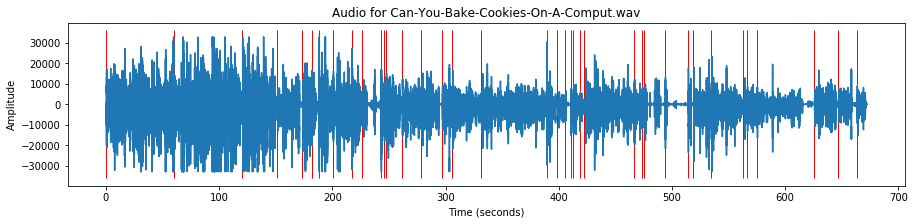

In [15]:
print("Sentences transcribed: {}".format(transcription["volume"]))
time = np.linspace(0, get_duration(file_name), data.shape[0])
rcParams['figure.figsize'] = (15, 3)
plt.plot(time, data)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Audio for {}".format(file_name_short))

lower, upper = plt.ylim()
for sentence in transcription["results"]:
    x = sentence["words"][0]["start"]
    plt.vlines(x, lower, upper, color="red", linewidth=1)

plt.show()

#### Look at transcription results

In [16]:
for index, result in enumerate(transcription["results"]):
    # print("Sentence {}".format(index+1))
    frame("Sentence {}".format(index+1))
    transcript = result["transcript"]
    words = result["words"]
    confidence = result["confidence"]

    print("Confidence: {}".format(confidence))
    print("Transcript: \n\"{}\"\n".format(transcript))
    
    print(get_tabulated_words(words), end="\n\n\n")

+------------+
| Sentence 1 |
+------------+
Confidence: 0.9721750617027283
Transcript: 
"do you want to know what happens when you bake cookies on a computer processor that's what we're going to be doing today today this is cooking with Jay everyone's favorite serious or we bake some assorted piece of food on computer hardware to find out if it's possible and they were doing chocolate chip cookies now why are we actually doing cooking on a text Channel and ask that question I have no idea but you know it's a lot better to say I have a cooking channel to some girls and it is to say I have a text channel so we're going to see how well that works out for us so I hope you guys are ready for this phone because I'm also going to be eating them taste testing them and seeing how good they taste so we've got a couple of gredients here we've got ourselves some vanilla extract which will be for a cookie of course they're a little bowl we also have our cooking meth abuse and cupcakes to put that 

In [17]:
from google.cloud import speech_v1


def sample_long_running_recognize(storage_uri):
    """
    Print start and end time of each word spoken in audio file from Cloud Storage

    Args:
      storage_uri URI for audio file in Cloud Storage, e.g. gs://[BUCKET]/[FILE]
    """

    client = speech_v1.SpeechClient()

    # storage_uri = 'gs://cloud-samples-data/speech/brooklyn_bridge.flac'

    # When enabled, the first result returned by the API will include a list
    # of words and the start and end time offsets (timestamps) for those words.
    enable_word_time_offsets = True

    # The language of the supplied audio
    language_code = "en-US"
    config = {
        "enable_word_time_offsets": enable_word_time_offsets,
        "language_code": language_code,
    }
    audio = {"uri": storage_uri}

    operation = client.long_running_recognize(config, audio)

    print(u"Waiting for operation to complete...")
    response = operation.result()

    # The first result includes start and end time word offsets
    result = response.results[0]
    # First alternative is the most probable result
    alternative = result.alternatives[0]
    print(u"Transcript: {}".format(alternative.transcript))
    # Print the start and end time of each word
    for word in alternative.words:
        print(u"Word: {}".format(word.word))
        print(
            u"Start time: {} seconds {} nanos".format(
                word.start_time.seconds, word.start_time.nanos
            )
        )
        print(
            u"End time: {} seconds {} nanos".format(
                word.end_time.seconds, word.end_time.nanos
            )
        )


1. copyright infringment on using youtube videos
2. 15-20 papers in a week
3. Read abstract, introduction and conclusion for all, entire paper for three to five
4. Plan a Thesis meeting
5. Setup Github for code for paper